# Modeling 



## Table of Contents
1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Modeling process](#Modeling-Process)
4. [Key Metrics](#Key-Metrics)
5. [Results](#Results)



# Introduction <a id="Introduction"></a>
The goal of the project is to provide Swire Coca-Cola with the ability to predict future unplanned maintenance events and minimize downtime. Unplanned maintenance can lead to significant operational losses. Our primary analytical challenge will be identifying the variables that can predict machine breakdowns. Key target variables will include actual work in minutes and maintenance activity type.

# Data Preparation <a id="Data-Preparation"></a>

In [1]:
# Package Importing and Data Cleaning 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
df = pd.read_csv('IWC_Work_Orders_Extract.csv', low_memory=False)

#remove columns not needed 

columns_to_remove = [
    'EQUIPMENT_DESC', 
    'EQUIP_CAT_DESC', 
    'EQUIP_START_UP_DATE', 
    'EQUIP_VALID_FROM', 
    'EQUIP_VALID_TO', 
    'EXECUTION_FINISH_DATE', 
    'ACTUAL_START_TIME', 
    'ACTUAL_FINISH_TIME', 
    'EXECUTION_START_DATE'
]

df = df.drop(columns=columns_to_remove)

# Convert date columns to datetime
df['ACTUAL_WORK_IN_MINUTES'] = pd.to_numeric(df['ACTUAL_WORK_IN_MINUTES'], errors='coerce')

# Remove duplicate rows
df.drop_duplicates(inplace=True)


#take a quick look at the data to ensure it looks good 
print("Columns:", df.columns.tolist(), "\n", df.head())



Columns: ['ORDER_ID', 'PLANT_ID', 'PRODUCTION_LOCATION', 'ACTUAL_WORK_IN_MINUTES', 'MAINTENANCE_PLAN', 'MAINTENANCE_ITEM', 'MAINTENANCE_ACTIVITY_TYPE', 'ORDER_DESCRIPTION', 'MAINTENANCE_TYPE_DESCRIPTION', 'FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_1_MODIFIED', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'FUNCTIONAL_AREA_NODE_4_MODIFIED', 'FUNCTIONAL_AREA_NODE_5_MODIFIED', 'EQUIPMENT_ID'] 
     ORDER_ID PLANT_ID PRODUCTION_LOCATION  ACTUAL_WORK_IN_MINUTES  \
0  705642457     G812                ROMA                   390.0   
1  704191697     G812                ROMA                   420.0   
2  704466547     G812                ROMA                    30.0   
3  703834477     G812                ROMA                    60.0   
4  704661125     G291               MONZA                   120.0   

  MAINTENANCE_PLAN  MAINTENANCE_ITEM MAINTENANCE_ACTIVITY_TYPE  \
0              NaN               NaN                 Unplanned   
1              NaN               NaN 

# Modeling Process A <a id="Modeling-Process"></a>
Let’s examine the relationship between planned and unplanned work, as well as key problem areas, so that we can build a useful tool based on real-world pain points.

In [2]:
# Calculate the ratio of "unplanned" to "planned" maintenance activities
maintenance_activity_counts = df['MAINTENANCE_ACTIVITY_TYPE'].value_counts()
unplanned_count = maintenance_activity_counts['Unplanned'] if 'Unplanned' in maintenance_activity_counts else 0
planned_count = maintenance_activity_counts['Planned'] if 'Planned' in maintenance_activity_counts else 0
ratio = unplanned_count / (planned_count + unplanned_count) if planned_count + unplanned_count > 0 else 0

print(f"Ratio of 'unplanned' to 'planned' maintenance activities: {ratio}")



Ratio of 'unplanned' to 'planned' maintenance activities: 0.8946326678175867


### Insights
For every one planned maintenance activity, there are approximately 0.8946 unplanned maintenance activities. Let's examine the counts as well to get a better understanding of the scale.

In [3]:
# Count the number of occurrences of each value in the MAINTENANCE_ACTIVITY_TYPE column
counts = df['MAINTENANCE_ACTIVITY_TYPE'].value_counts()

# Print the counts
print(counts)



Unplanned    1276877
Planned       150387
Name: MAINTENANCE_ACTIVITY_TYPE, dtype: int64


Let’s examine which plants have the highest ratio of planned to unplanned maintenance activities.

In [4]:

# Group the data by PLANT_ID and calculate the counts of 'unplanned' and 'planned' maintenance activities
grouped_df_pl = df.groupby('PRODUCTION_LOCATION')['MAINTENANCE_ACTIVITY_TYPE'].value_counts().unstack()

# Rename the columns
grouped_df_pl.columns = ['Planned', 'Unplanned']

# Calculate the ratio of 'unplanned' to 'planned' maintenance activities
grouped_df_pl['Ratio'] = grouped_df_pl['Unplanned'] / grouped_df_pl['Planned']

# Print the dataframe
print(grouped_df_pl)





                     Planned  Unplanned      Ratio
PRODUCTION_LOCATION                               
COTA                   26338      89965   3.415787
MONACO                  8150      76544   9.391902
MONZA                  48658     176621   3.629845
ROMA                   21222      57888   2.727735
SILVERSTONE            27809     603094  21.687008
SUZUKA                 18210     272765  14.978858


Silverstone and Suzuka are both outliers, showing underperformance. Now that we have a broad understanding, let’s identify the specific functional locations that would benefit the most from implementing more planned maintenance.

In [5]:


# Group the data by PLANT_ID and calculate the counts of 'unplanned' and 'planned' maintenance activities
grouped_df_fM = df.groupby('FUNCTIONAL_LOC')['MAINTENANCE_ACTIVITY_TYPE'].value_counts().unstack()

# Rename the columns
grouped_df_fM.columns = ['Planned', 'Unplanned']

# Calculate the ratio of 'unplanned' to 'planned' maintenance activities
grouped_df_fM['Ratio'] = grouped_df_fM['Unplanned'] / grouped_df_fM['Planned']

# Sort the dataframe by the Ratio column in descending order
grouped_df_fMf = grouped_df_fM.sort_values(by='Ratio', ascending=False)

# Print the dataframe
print(grouped_df_fMf)





                       Planned  Unplanned       Ratio
FUNCTIONAL_LOC                                       
G221-PRD-L30-L06-L010      1.0      209.0  209.000000
G221-PRD-L30-L02-L070      3.0      511.0  170.333333
G221-PRD-L15-L04-L200      1.0      145.0  145.000000
G811-PRD-A55-I04           1.0      136.0  136.000000
G221-PRD-L30-L06-L070      1.0      131.0  131.000000
...                        ...        ...         ...
G816-PRD-P90-W02-S090      NaN        1.0         NaN
G816-PRD-P90-W06           NaN        2.0         NaN
G816-PRD-P90-W10           NaN        5.0         NaN
G816-PRD-P90-XXX-S210      NaN        5.0         NaN
G999-SLC-PRD               NaN        1.0         NaN

[667 rows x 3 columns]


G221-PRD-L30-L02-L070 has a poor ratio and a slightly larger sample size, so let's use that one.

# Modeling Process B <a id="Modeling-Process"></a>
Another avenue of analysis is to develop a classification model to predict whether a maintenance task is likely to be planned or unplanned. This can help in identifying potential unplanned maintenance scenarios beforehand. Afterward, we can incorporate a regression model to predict ACTUAL_WORK_IN_MINUTES as a proxy for downtime.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, r2_score

# Ensure the dataset has already been cleaned and prepared prior to this code.
# Encode categorical features
label_encoders = {}
for column in ['PLANT_ID', 'PRODUCTION_LOCATION', 'MAINTENANCE_TYPE_DESCRIPTION', 'FUNCTIONAL_LOC']:
    if column in df.columns and df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le

# Create the target variable for classification
if 'MAINTENANCE_ACTIVITY_TYPE' in df.columns:
    df['TARGET_CLASS'] = (df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned').astype(int)

# Handle missing values for numeric columns only
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Ensure only numeric columns are used for modeling
X_classification = df.select_dtypes(include=[np.number]).drop(columns=['ACTUAL_WORK_IN_MINUTES', 'TARGET_CLASS'], errors='ignore')
y_classification = df['TARGET_CLASS']

# Splitting data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification, y_classification, test_size=0.3, random_state=42
)

# Classification model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_class, y_train_class)

# Predictions and evaluation
y_pred_class = clf.predict(X_test_class)
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

# Feature importance
feature_importances = pd.Series(clf.feature_importances_, index=X_classification.columns)
print("\nTop Features for Classification:")
print(feature_importances.sort_values(ascending=False).head(10))

# Regression model
# Using 'ACTUAL_WORK_IN_MINUTES' as the target variable
X_regression = df.select_dtypes(include=[np.number]).drop(columns=['ACTUAL_WORK_IN_MINUTES', 'TARGET_CLASS'], errors='ignore')
y_regression = df['ACTUAL_WORK_IN_MINUTES']

# Splitting data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.3, random_state=42
)

# Regression model
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predictions and evaluation
y_pred_reg = reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\nRegression Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Feature importance for regression
feature_importances_reg = pd.Series(reg.feature_importances_, index=X_regression.columns)
print("\nTop Features for Regression:")
print(feature_importances_reg.sort_values(ascending=False).head(10))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45294
           1       1.00      1.00      1.00    382886

    accuracy                           1.00    428180
   macro avg       1.00      1.00      1.00    428180
weighted avg       1.00      1.00      1.00    428180


Top Features for Classification:
MAINTENANCE_TYPE_DESCRIPTION    0.356272
MAINTENANCE_ITEM                0.349656
EQUIPMENT_ID                    0.165952
FUNCTIONAL_LOC                  0.104616
ORDER_ID                        0.010375
PRODUCTION_LOCATION             0.006981
PLANT_ID                        0.006149
dtype: float64

Regression Evaluation:
Mean Squared Error: 547690.26
R-squared: -0.40

Top Features for Regression:
ORDER_ID                        0.929642
PLANT_ID                        0.032943
PRODUCTION_LOCATION             0.028859
EQUIPMENT_ID                    0.003257
FUNCTIONAL_LOC                  0.002412
MAINTENA

# Additional Visualization and Analysis


Maintenance Analysis Summary

Top 5 High-Risk Equipment:
   Equipment Risk_Level  Current_Unplanned_Ratio  \
0         10       High                     0.79   
1         13       High                     0.73   
2         14       High                     0.95   
3         18       High                     0.96   
4         21       High                     0.99   

                                      Recommendation  \
0  Implement preventive maintenance every 89 minutes   
1  Implement preventive maintenance every 106 min...   
2  Implement preventive maintenance every 118 min...   
3  Implement preventive maintenance every 118 min...   
4  Implement preventive maintenance every 117 min...   

                                    Expected_Impact  
0  Potential cost savings of $1,695,720.00 annually  
1  Potential cost savings of $4,637,160.00 annually  
2  Potential cost savings of $1,721,160.00 annually  
3  Potential cost savings of $6,374,040.00 annually  
4  Potential cost savi

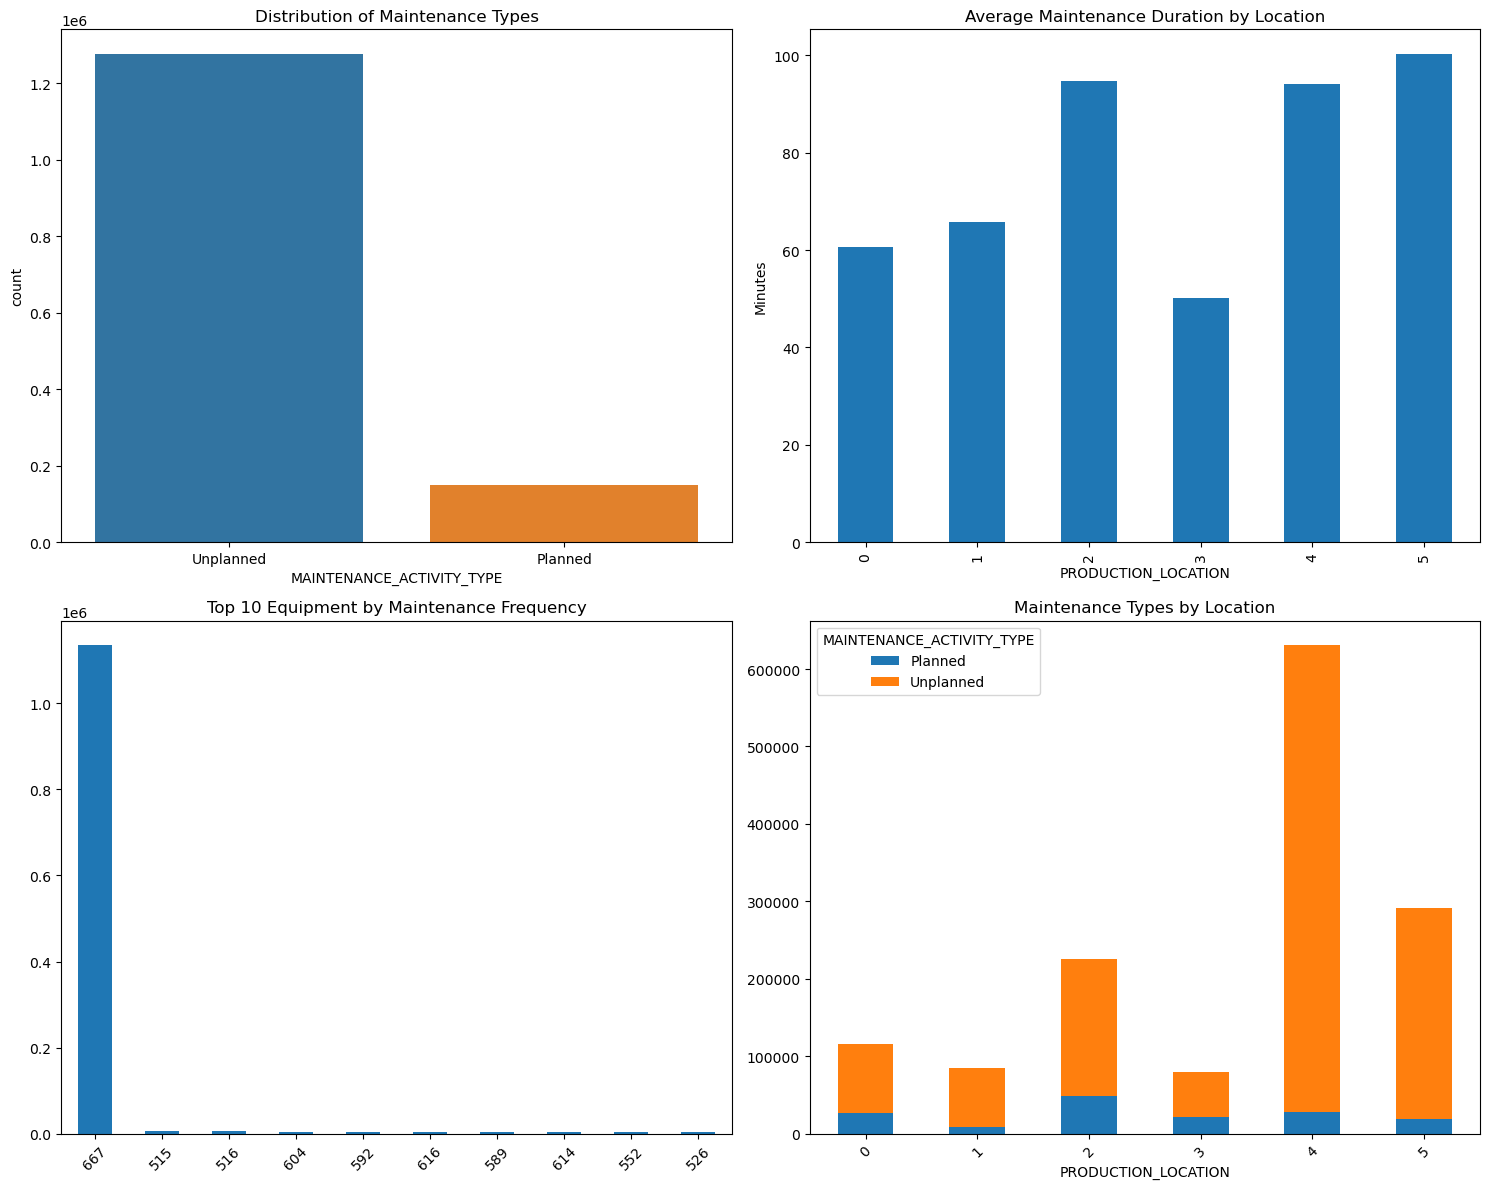

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Your existing data loading and cleaning code here...

# Add visualization functions
def plot_maintenance_patterns():
    """Create visualizations for maintenance patterns"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Maintenance Type Distribution
    sns.countplot(data=df, x='MAINTENANCE_ACTIVITY_TYPE', ax=ax1)
    ax1.set_title('Distribution of Maintenance Types')
    ax1.tick_labels_rotation = 45
    
    # 2. Average Maintenance Duration by Location
    avg_duration = df.groupby('PRODUCTION_LOCATION')['ACTUAL_WORK_IN_MINUTES'].mean()
    avg_duration.plot(kind='bar', ax=ax2)
    ax2.set_title('Average Maintenance Duration by Location')
    ax2.set_ylabel('Minutes')
    
    # 3. Top Equipment by Maintenance Frequency
    equipment_counts = df['FUNCTIONAL_LOC'].value_counts().head(10)
    equipment_counts.plot(kind='bar', ax=ax3)
    ax3.set_title('Top 10 Equipment by Maintenance Frequency')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Maintenance Type Distribution by Location
    maintenance_by_location = pd.crosstab(df['PRODUCTION_LOCATION'], df['MAINTENANCE_ACTIVITY_TYPE'])
    maintenance_by_location.plot(kind='bar', stacked=True, ax=ax4)
    ax4.set_title('Maintenance Types by Location')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

# Add analysis functions
def calculate_equipment_metrics():
    """Calculate key metrics for each piece of equipment"""
    equipment_metrics = df.groupby('FUNCTIONAL_LOC').agg({
        'ACTUAL_WORK_IN_MINUTES': ['mean', 'sum', 'count'],
        'MAINTENANCE_ACTIVITY_TYPE': lambda x: (x == 'Unplanned').mean()
    }).round(2)
    
    equipment_metrics.columns = ['Avg_Duration', 'Total_Duration', 'Maintenance_Count', 'Unplanned_Ratio']
    
    # Calculate cost impact (assuming $100/minute downtime)
    equipment_metrics['Estimated_Cost_Impact'] = equipment_metrics['Total_Duration'] * 100
    
    return equipment_metrics

def generate_recommendations(equipment_metrics):
    """Generate maintenance recommendations based on metrics"""
    recommendations = []
    
    # Identify high-risk equipment
    high_risk = equipment_metrics[
        (equipment_metrics['Unplanned_Ratio'] > 0.7) & 
        (equipment_metrics['Maintenance_Count'] > equipment_metrics['Maintenance_Count'].median())
    ]
    
    for equip in high_risk.index:
        metrics = high_risk.loc[equip]
        recommendations.append({
            'Equipment': equip,
            'Risk_Level': 'High',
            'Current_Unplanned_Ratio': metrics['Unplanned_Ratio'],
            'Recommendation': f"Implement preventive maintenance every {int(metrics['Avg_Duration'])} minutes",
            'Expected_Impact': f"Potential cost savings of ${metrics['Estimated_Cost_Impact']:,.2f} annually"
        })
    
    return pd.DataFrame(recommendations)

# Function to evaluate model performance over time
def evaluate_temporal_performance(X_test_class, y_test_class, clf):
    """Evaluate how the model performs over different time periods"""
    if 'NOTIFICATION_DATE' in df.columns:
        df['NOTIFICATION_DATE'] = pd.to_datetime(df['NOTIFICATION_DATE'])
        temporal_performance = {}
        
        # Evaluate by quarter
        for quarter in df['NOTIFICATION_DATE'].dt.quarter.unique():
            mask = df['NOTIFICATION_DATE'].dt.quarter == quarter
            if mask.sum() > 0:
                quarter_score = clf.score(
                    X_test_class[mask], 
                    y_test_class[mask]
                )
                temporal_performance[f'Q{quarter}'] = quarter_score
                
        return pd.Series(temporal_performance)
    return None

# Add main execution code
def main():
    # Your existing model training code here...
    
    # Generate visualizations
    maintenance_patterns_fig = plot_maintenance_patterns()
    
    # Calculate equipment metrics
    equipment_metrics = calculate_equipment_metrics()
    
    # Generate recommendations
    recommendations = generate_recommendations(equipment_metrics)
    
    # Evaluate temporal performance
    temporal_perf = evaluate_temporal_performance(X_test_class, y_test_class, clf)
    
    # Print summary results
    print("\nMaintenance Analysis Summary")
    print("="*50)
    print("\nTop 5 High-Risk Equipment:")
    print(recommendations.head())
    
    print("\nModel Performance Across Time Periods:")
    if temporal_perf is not None:
        print(temporal_perf)
    
    print("\nTop Equipment by Maintenance Cost Impact:")
    print(equipment_metrics.nlargest(5, 'Estimated_Cost_Impact')[['Total_Duration', 'Estimated_Cost_Impact']])
    
    # Save visualizations
    maintenance_patterns_fig.savefig('maintenance_patterns.png')
    
    return {
        'equipment_metrics': equipment_metrics,
        'recommendations': recommendations,
        'temporal_performance': temporal_perf
    }

if __name__ == "__main__":
    results = main()


# Key Metrics <a id="Key-Metrics"></a>
For the functional location G221-PRD-L30-L02-L070, the ratio of planned to unplanned maintenance events is 3:511, or approximately 170.

Let’s create a calculator to determine the optimal amount of planned maintenance needed to minimize costs for our selected problematic location. Since we do not have access to financial data on a per-hour basis, we will use the following assumptions: 50 Dollors per hour for planned maintenance and 500 Dollord per hour for unplanned maintenance, which includes losses from not stopping production. Additionally, we need to enter the ratio of planned to unplanned work, which in our case is 170.

In [ ]:
def break_even_point_calculator():
    # Get the user input
    cost_per_hour_planned = float(input("Enter the monetary cost per hour of planned maintenance: $"))
    cost_per_hour_unplanned = float(input("Enter the monetary cost per hour of unplanned maintenance (including compensation for lost production): $"))
    ratio_planned_to_unplanned = float(input("Enter the ratio of planned to unplanned maintenance events (e.g. 170.33 for 3 planned and 511 unplanned events): "))

    # Calculate the break-even point
    break_even_point = (cost_per_hour_unplanned / cost_per_hour_planned) * (1 / ratio_planned_to_unplanned)

    print(f"The break-even point is: {break_even_point:.2f} hours of planned maintenance per hour of unplanned maintenance.")

    # Calculate the number of hours of planned maintenance needed
    hours_planned = break_even_point * ratio_planned_to_unplanned
    print(f"The number of hours of planned maintenance needed is: {hours_planned:.2f} hours.")

    # Calculate the cost of planned maintenance
    cost_planned = hours_planned * cost_per_hour_planned
    print(f"The cost of planned maintenance is: ${cost_planned:.2f}.")

    # Calculate the value of unplanned maintenance avoided
    value_avoided = cost_per_hour_unplanned * ratio_planned_to_unplanned
    print(f"The value of unplanned maintenance avoided is: ${value_avoided:.2f}.")

break_even_point_calculator()

# Results <a id="Results"></a>
According to the break-even analysis, Swire should perform 10 hours of planned maintenance for the functional location G221-PRD-L30-L02-L070, which will cost them 500 Dollors. By doing so, they will save 85,000 Dollors. While these savings may seem quite extreme, we selected one of the least efficient functional locations and made certain assumptions regarding the cost per hour. When applied to functional locations with more average performance, the results will normalize.